# Simulated binary tree data

In [1]:
import ocelli as oci

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200

SEED=17

## Load the data

In [3]:
import scanpy as scp

adata = scp.read_h5ad('../../../data/binary-tree-dataset.h5ad')
adata

AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'modalities'
    obsm: 'modality0', 'modality1', 'modality2'

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

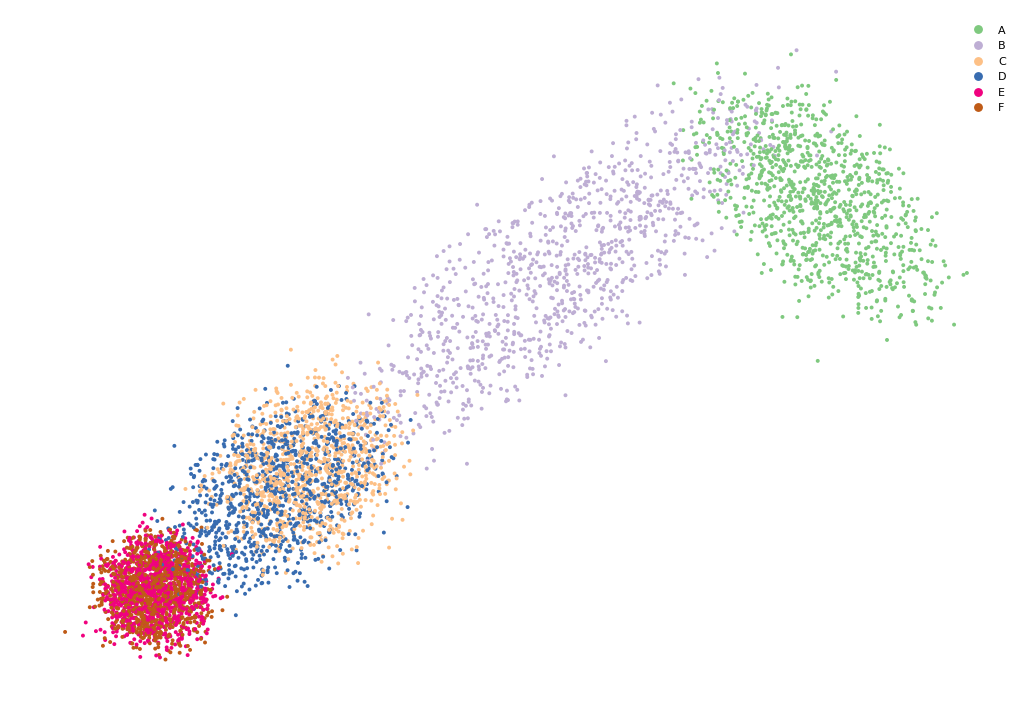

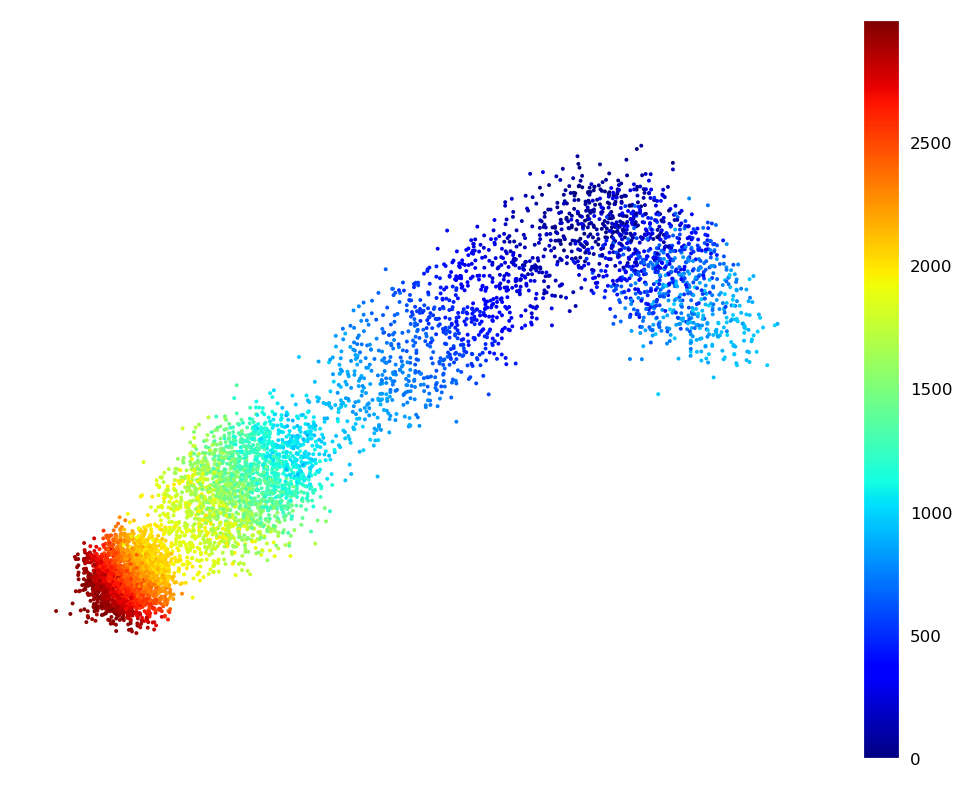

In [4]:
oci.tl.project_2d(adata, x3d_key='modality0', output_key='modality0_proj', alpha=30, beta=0)
oci.pl.scatter(adata, x_key='modality0_proj', color_key='celltype', marker_size=2, cmap='Accent')
oci.pl.scatter(adata, x_key='modality0_proj', color_key='pseudotime', marker_size=2, cmap='jet')

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

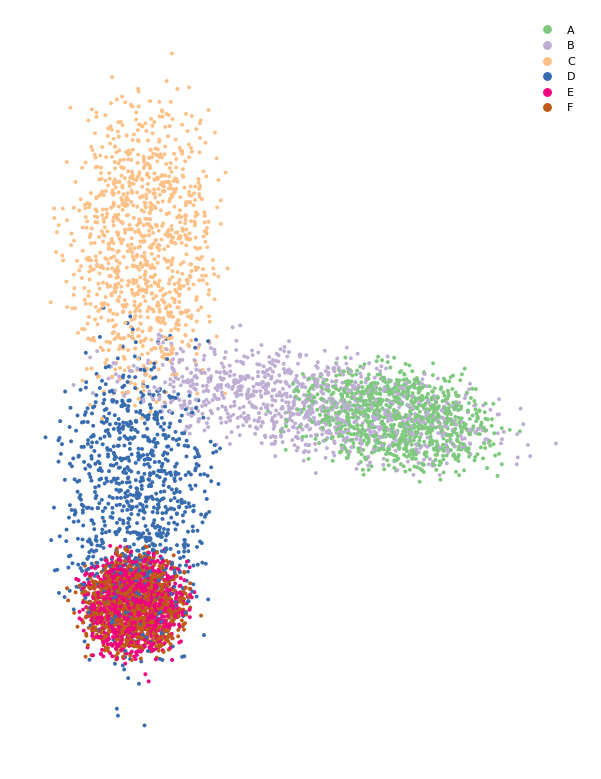

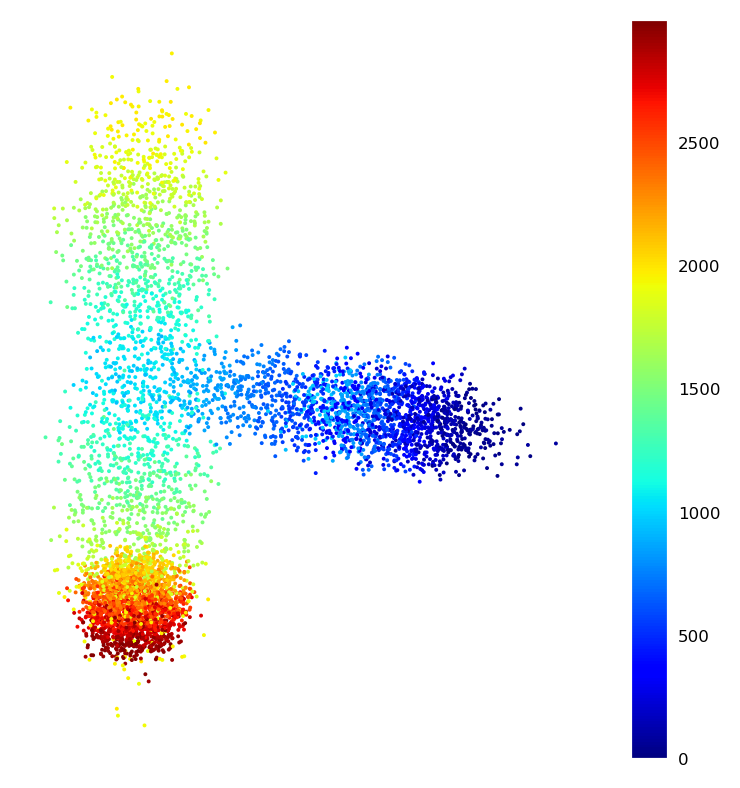

In [5]:
oci.tl.project_2d(adata, x3d_key='modality1', output_key='modality1_proj', alpha=--60, beta=60)
oci.pl.scatter(adata, x_key='modality1_proj', color_key='celltype', marker_size=2, cmap='Accent')
oci.pl.scatter(adata, x_key='modality1_proj', color_key='pseudotime', marker_size=2, cmap='jet')

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

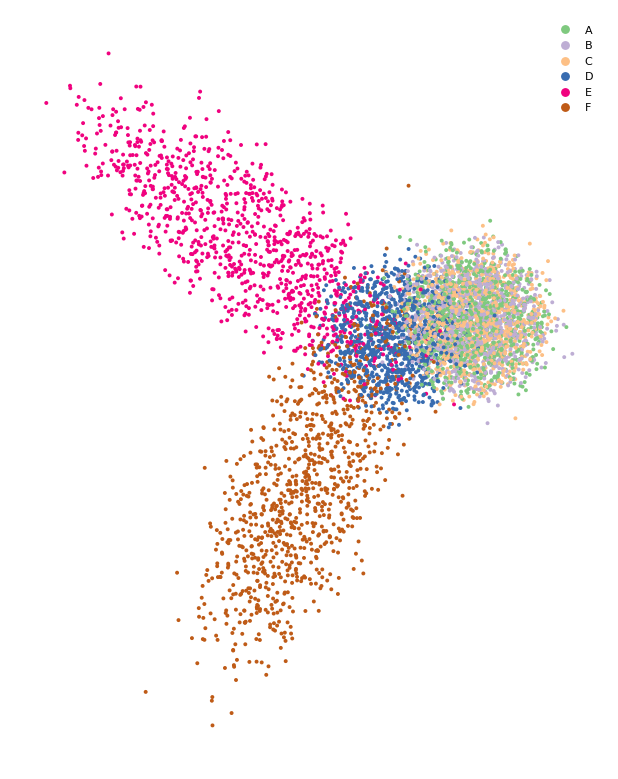

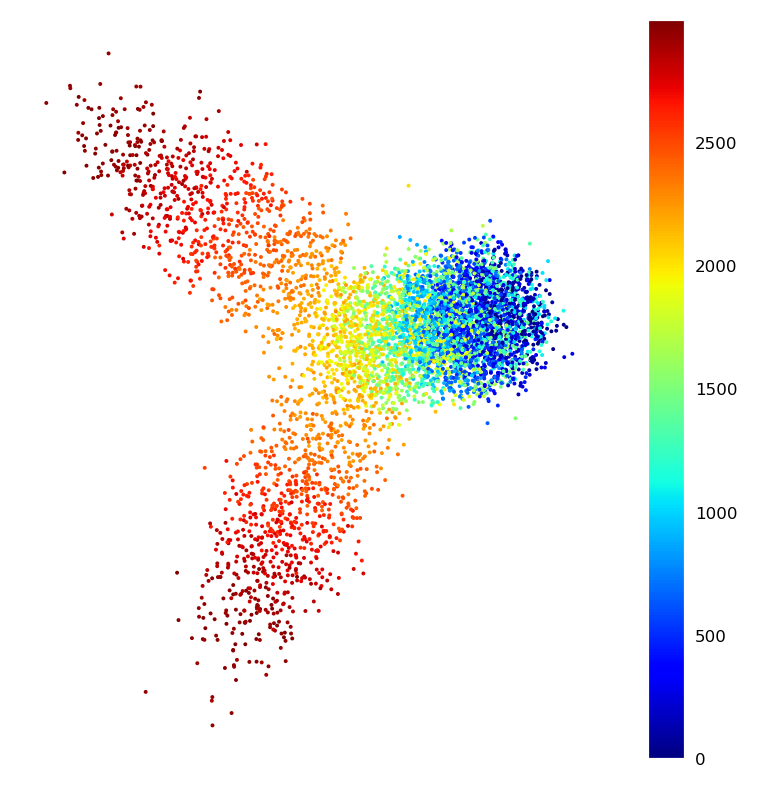

In [6]:
oci.tl.project_2d(adata, x3d_key='modality2', output_key='modality2_proj', alpha=30, beta=30)
oci.pl.scatter(adata, x_key='modality2_proj', color_key='celltype', marker_size=2, cmap='Accent')
oci.pl.scatter(adata, x_key='modality2_proj', color_key='pseudotime', marker_size=2, cmap='jet')

## Calculate Multimodal Diffusion Maps components

In [7]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)

[modality0] 20 nearest neighbors calculated.
[modality1] 20 nearest neighbors calculated.
[modality2] 20 nearest neighbors calculated.


2022-10-04 19:32:05,838	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal cell-specific weights estimated.


In [8]:
adata.obsm['weights']

,modality0,modality1,modality2
0,0.973592,0.025576,0.000832
1,0.989186,0.008797,0.002017
2,0.992478,0.006181,0.001341
3,0.967995,0.030422,0.001583
4,0.993608,0.004865,0.001527
...,...,...,...
5995,0.000107,0.000101,0.999793
5996,0.000115,0.000101,0.999784
5997,0.000117,0.000101,0.999782
5998,0.000159,0.000095,0.999746


(<Figure size 1440x480 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'A'}, ylabel='modality0'>,
         <AxesSubplot:title={'center':'B'}>,
         <AxesSubplot:title={'center':'C'}>,
         <AxesSubplot:title={'center':'D'}>,
         <AxesSubplot:title={'center':'E'}>,
         <AxesSubplot:title={'center':'F'}>],
        [<AxesSubplot:ylabel='modality1'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='modality2'>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

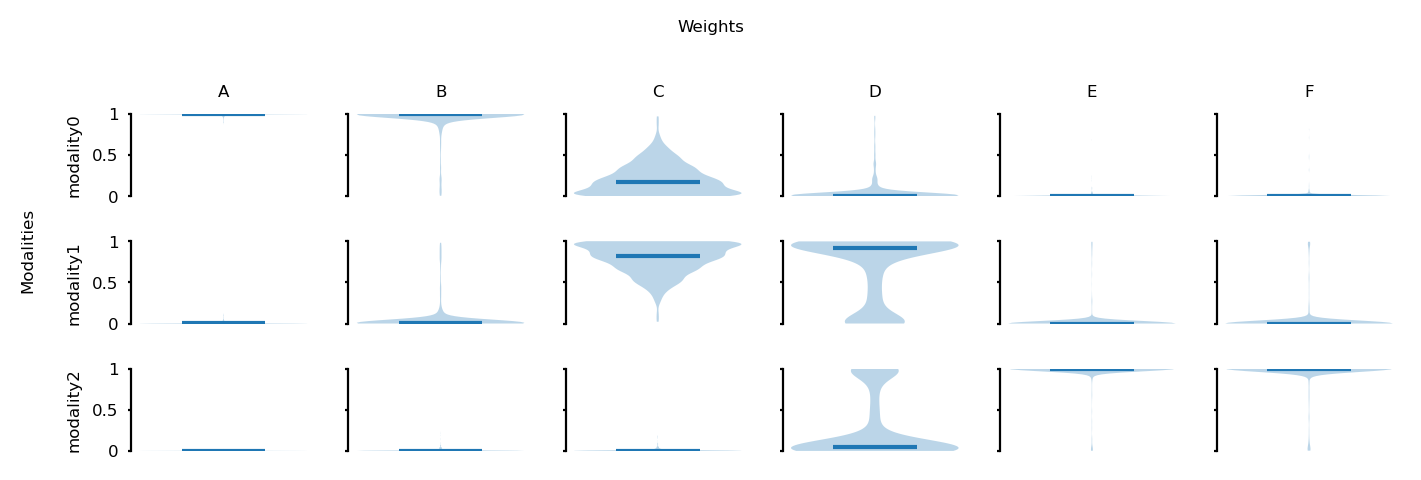

In [9]:
oci.pl.weights(adata, grouping_key='celltype')

In [10]:
oci.tl.MDM(adata, n_components=10, unimodal_norm=False, verbose=True, random_state=SEED)
adata

2022-10-04 19:32:13,449	INFO worker.py:1518 -- Started a local Ray instance.


[modality0] Unimodal Markov chain calculated
[modality1] Unimodal Markov chain calculated
[modality2] Unimodal Markov chain calculated
Multimodal Markov chain calculated
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.


AnnData object with n_obs × n_vars = 6000 × 1
    obs: 'celltype', 'pseudotime'
    uns: 'modalities'
    obsm: 'modality0', 'modality1', 'modality2', 'modality0_proj', 'modality1_proj', 'modality2_proj', 'neighbors_modality0', 'distances_modality0', 'neighbors_modality1', 'distances_modality1', 'neighbors_modality2', 'distances_modality2', 'weights', 'X_mdm'

## Visualize the data

In [11]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=30, verbose=True)
oci.tl.nn_graph(adata, n_edges=30, neighbors_key='X_mdm', verbose=True)

[X_mdm] 30 nearest neighbors calculated.
[X_mdm] Nearest neighbors-based graph constructed.


In [12]:
oci.tl.FA2(adata, n_components=2, n_iter=5000, random_state=SEED, output_key='X_fa2')

Oct 04, 2022 7:32:28 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 04, 2022 7:32:29 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 6,000 (6,000 added)
Oct 04, 2022 7:32:29 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 180,000 (108,678 added)


*************************25%
*************************50%
*************************75%
************

*************100%
Time = 36.121s


(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

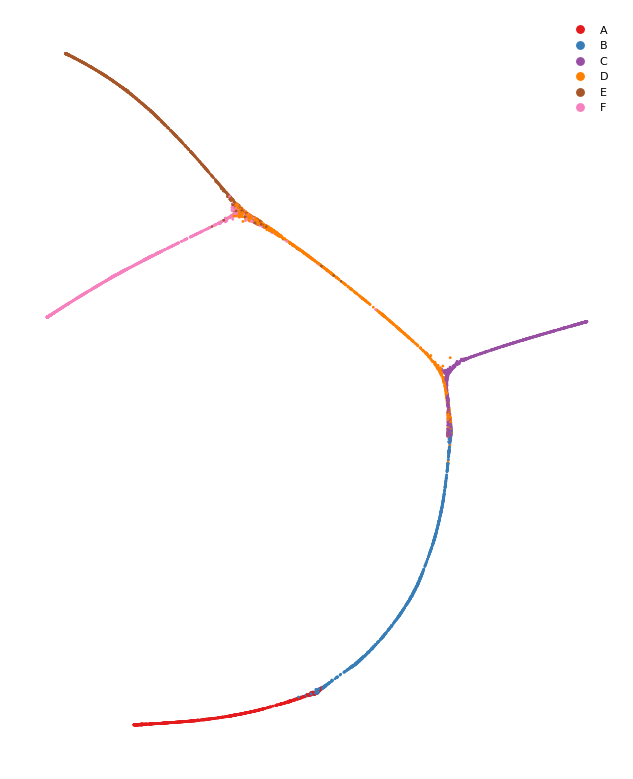

In [13]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='celltype', cmap='Set1', marker_size=1)

Cell development pseudotime:

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

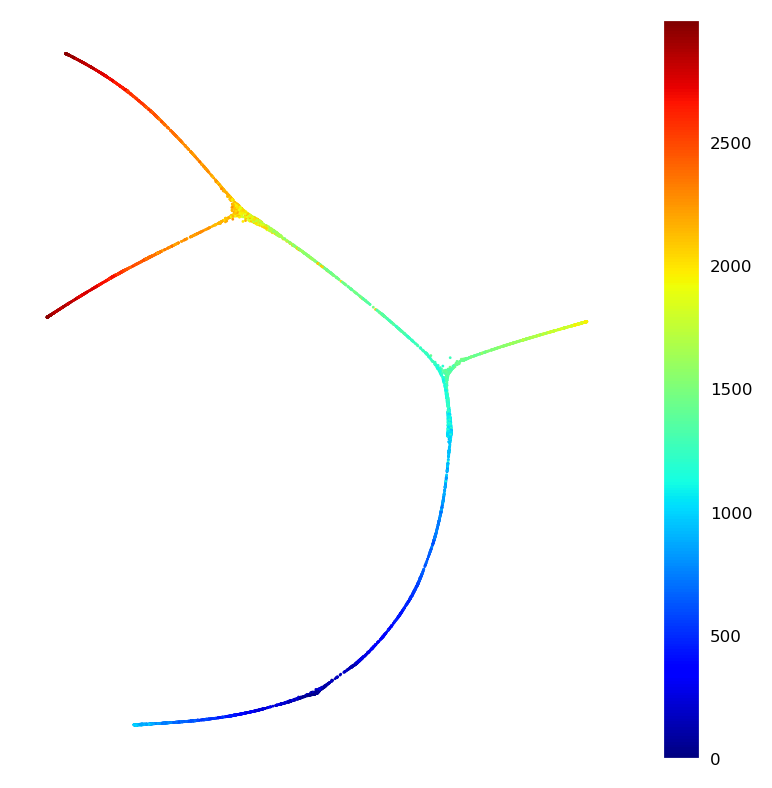

In [14]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='pseudotime', cmap='jet', marker_size=1)

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

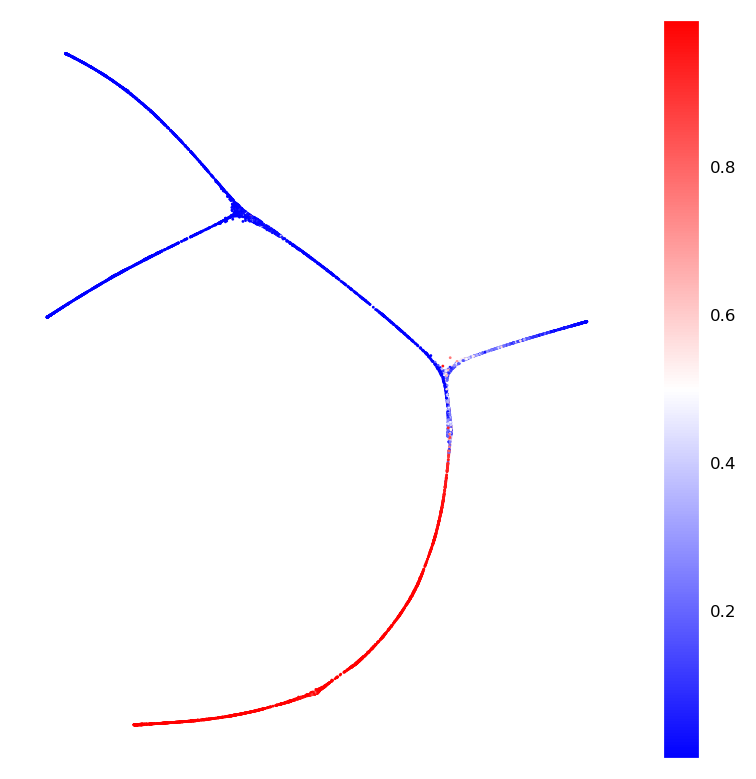

In [15]:
adata.obs['w_m0'] = list(adata.obsm['weights']['modality0'])
oci.pl.scatter(adata, x_key='X_fa2', color_key='w_m0', cmap='bwr', marker_size=1)

The second view's weights:

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

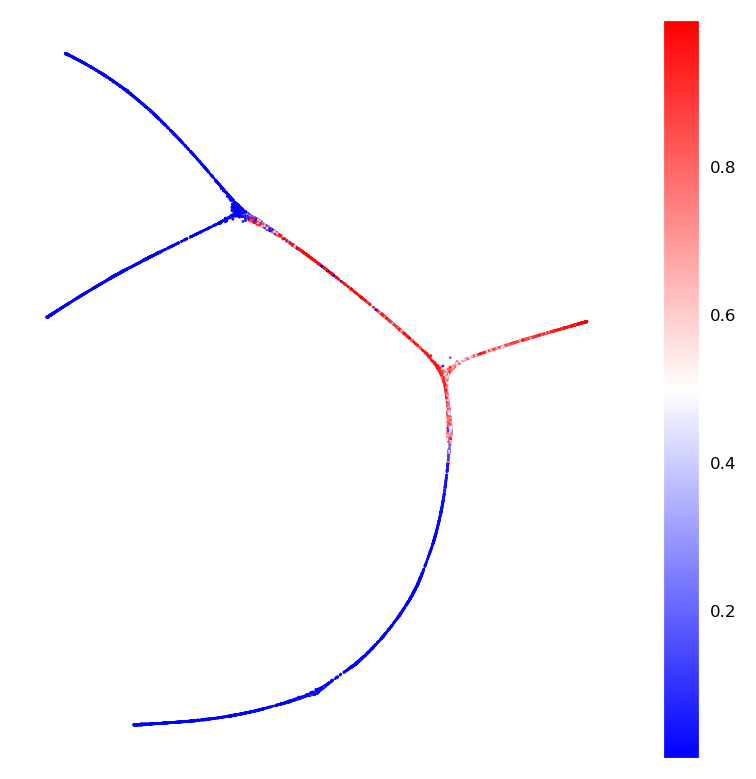

In [16]:
adata.obs['w_m1'] = list(adata.obsm['weights']['modality1'])
oci.pl.scatter(adata, x_key='X_fa2', color_key='w_m1', cmap='bwr', marker_size=1)

(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

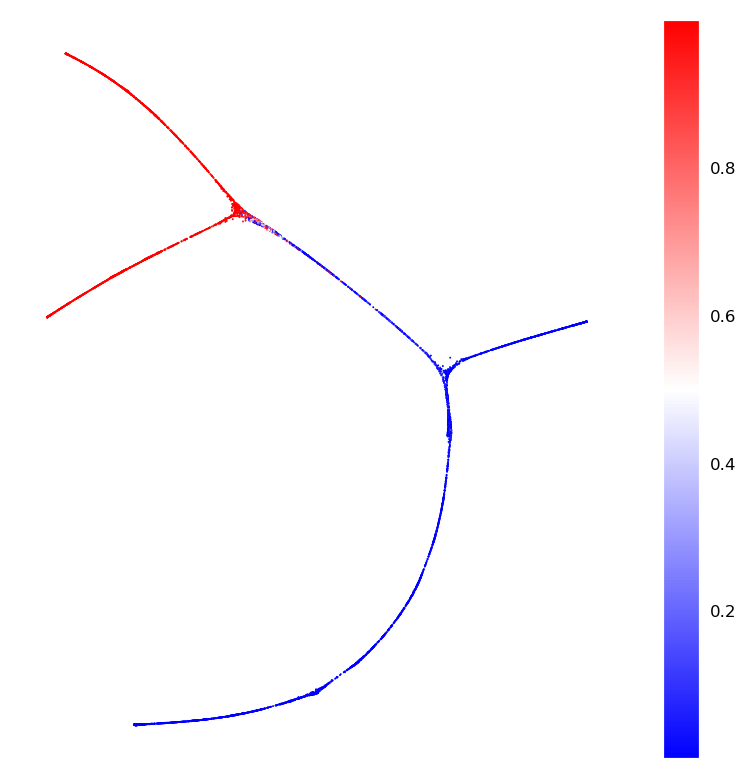

In [17]:
adata.obs['w_m2'] = list(adata.obsm['weights']['modality2'])
oci.pl.scatter(adata, x_key='X_fa2', color_key='w_m2', cmap='bwr', marker_size=0.5)